### Machine Learning Engineer Nanodegree

# Capstone Project

## Telstra Network Disruptions Project

## Notebook 2:  One-hot encoding

This is a project to build a model that predict a level of fault severity at a time and a location in thier network using log data.

The dataset for this project originally came from Kaggle's past competition page:

[Telstra Network Disruptions in Kaggle](https://www.kaggle.com/c/telstra-recruiting-network)


In this notebook, I preprocess data, train models, apply refinements, and evaluate the result.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# helper module for this project
from telstra_helper import getint, read_tables

%matplotlib inline

In [2]:
# set display option to show all columns
pd.options.display.max_columns=None

## 1. Read data 

Read csv files and load data into Pandas DataFrames.

In [3]:
files = read_tables()

data_main = files['train.csv']
log_feature = files['log_feature.csv']
severity_type = files['severity_type.csv']
event_type = files['event_type.csv']
resource_type = files['resource_type.csv']


----- train.csv -----


,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


id                 int64
location          object
fault_severity     int64
dtype: object


----- log_feature.csv -----


,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


id              int64
log_feature    object
volume          int64
dtype: object


----- severity_type.csv -----


,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


id                int64
severity_type    object
dtype: object


----- event_type.csv -----

event_type.csv :Number of wrong rows = 1, positions = [31171]



,id,event_type,event_flag
1,6597,event_type 11,NaN
2,8011,event_type 15,NaN
3,2597,event_type 15,NaN
4,5022,event_type 15,NaN
5,5022,event_type 11,NaN


id              int64
event_type     object
event_flag    float64
dtype: object


----- resource_type.csv -----

resource_type.csv: Number of wrong rows = 1, positions = [21077]



,id,resource_type,resource_flag
1,6597,resource_type 8,NaN
2,8011,resource_type 8,NaN
3,2597,resource_type 8,NaN
4,5022,resource_type 8,NaN
5,6852,resource_type 8,NaN


id                 int64
resource_type     object
resource_flag    float64
dtype: object

## 2. Data Preprocess

### 2.1 One-hot encoding + Frequency table

Make input data by a conbination of one-hot encoding and frequency table.

 - For features that have just one feature type for an id, apply one-hot encoding.
 - For features that can have multiple feature types for an id, apply frequency table.

In [4]:
# Make labels of volumes (without this process, the columns would be just '1', '2' ...)
log_feature_new = log_feature.copy()
log_feature_new['volume'] = log_feature_new['volume'].apply(lambda x: "volume {}".format(x))
display(log_feature_new.head())

,id,log_feature,volume
0,6597,feature 68,volume 6
1,8011,feature 68,volume 7
2,2597,feature 68,volume 1
3,5022,feature 172,volume 2
4,5022,feature 56,volume 1


In [5]:
f_table = data_main.copy()

# One-hot encoding for 'location'
f_table = pd.get_dummies(f_table, columns=['location'], prefix='', prefix_sep='')

# One-hot encoding for 'severity_type'
st_ft = pd.get_dummies(severity_type, columns=['severity_type'], prefix='', prefix_sep='')
# concatenate severity_type
f_table = f_table.join(st_ft.set_index('id'), on='id')
f_table = f_table.reset_index().drop(['index'], axis=1)

print(" data_main <--- severity_type")

# make frequancy table for log_feature
# take rows if its id is in train.csv
log_feature_id = log_feature.loc[log_feature['id'].isin(data_main['id'])]
lf_ft = pd.crosstab(log_feature_id['id'], [log_feature_id['log_feature']], rownames=['id'], colnames=['log_feature'])
lf_ft['id'] = lf_ft.index
# convert volume number(int) to 'volume N'(string) 
lf_vol_str = log_feature_id['volume'].apply(lambda x: "volume {}".format(x))
# make frequancy table for volume
lf_ft_vol = pd.crosstab(log_feature_id['id'], [lf_vol_str], rownames=['id'], colnames=['volume'])
lf_ft_vol['id'] = lf_ft_vol.index
# concatenate log_feature
f_table = f_table.join(lf_ft.set_index('id'), on='id').reset_index().drop(['index'], axis=1)
f_table = f_table.join(lf_ft_vol.set_index('id'), on='id').reset_index().drop(['index'], axis=1)
print("           <--- log_feature")

# make frequency table for event_type
event_type_id = event_type.loc[event_type['id'].isin(data_main['id'])]
et_ft = pd.crosstab(event_type_id['id'], [event_type_id['event_type']], rownames=['id'], colnames=['event_type'])
et_ft['id'] = et_ft.index
# concatenate event_type
f_table = f_table.join(et_ft.set_index('id'), on='id').reset_index().drop(['index'], axis=1)
print("           <--- event_type")

# make frequency table for resource_type
resource_type_id = resource_type.loc[resource_type['id'].isin(data_main['id'])]
rt_ft = pd.crosstab(resource_type_id['id'], [resource_type_id['resource_type']], rownames=['id'], colnames=['resource_type'])
rt_ft['id'] = rt_ft.index
# concatenate event_type
f_table = f_table.join(rt_ft.set_index('id'), on='id').reset_index().drop(['index'], axis=1)
print("           <--- resource_type")

display(f_table.head())

 data_main <--- severity_type
           <--- log_feature
           <--- event_type
           <--- resource_type


,id,fault_severity,location 1,location 10,location 100,location 1000,location 1002,location 1005,location 1006,location 1007,location 1008,location 1009,location 101,location 1010,location 1011,location 1013,location 1014,location 1015,location 1016,location 1017,location 1018,location 1019,location 102,location 1020,location 1021,location 1022,location 1023,location 1024,location 1025,location 1026,location 1027,location 1029,location 103,location 1030,location 1031,location 1032,location 1033,location 1034,location 1035,location 1036,location 1037,location 1038,location 104,location 1041,location 1042,location 1044,location 1045,location 1046,location 1047,location 1048,location 1049,location 1050,location 1051,location 1052,location 1053,location 1054,location 1055,location 1056,location 1058,location 1059,location 106,location 1060,location 1061,location 1062,location 1063,location 1064,location 1065,location 1066,location 1067,location 1068,location 1069,location 107,location 1070,location 1071,location 1072,location 1073,location 1074,location 1075,location 1076,location 1077,location 1078,location 1079,location 108,location 1080,location 1081,location 1082,location 1083,location 1084,location 1086,location 1087,location 1088,location 1089,location 1090,location 1091,location 1092,location 1093,location 1094,location 1095,location 1096,location 1097,location 1098,location 1099,location 110,location 1100,location 1101,location 1102,location 1103,location 1104,location 1105,location 1106,location 1107,location 1108,location 1109,location 1110,location 1111,location 1112,location 1113,location 1115,location 1116,location 1117,location 1118,location 1119,location 112,location 1120,location 1121,location 1122,location 1125,location 1126,location 113,location 114,location 115,location 116,location 117,location 118,location 119,location 12,location 120,location 122,location 123,location 124,location 125,location 126,location 127,location 128,location 13,location 130,location 131,location 133,location 135,location 136,location 137,location 139,location 14,location 140,location 141,location 143,location 144,location 145,location 146,location 147,location 148,location 149,location 15,location 150,location 151,location 152,location 153,location 154,location 155,location 156,location 157,location 158,location 159,location 16,location 161,location 162,location 163,location 165,location 166,location 167,location 169,location 17,location 170,location 171,location 172,location 173,location 175,location 177,location 179,location 18,location 180,location 181,location 182,location 183,location 184,location 186,location 187,location 188,location 189,location 19,location 190,location 193,location 194,location 195,location 196,location 197,location 198,location 199,location 2,location 20,location 200,location 202,location 203,location 204,location 205,location 206,location 208,location 21,location 210,location 211,location 213,location 214,location 215,location 218,location 22,location 220,location 221,location 222,location 223,location 224,location 225,location 226,location 228,location 229,location 23,location 230,location 231,location 232,location 234,location 235,location 236,location 237,location 238,location 239,location 240,location 241,location 242,location 243,location 244,location 245,location 246,location 247,location 248,location 249,location 250,location 251,location 252,location 253,location 254,location 255,location 256,location 257,location 258,location 259,location 26,location 260,location 262,location 263,location 264,location 266,location 267,location 268,location 269,location 27,location 270,location 271,location 272,location 273,location 274,location 276,location 277,location 278,location 280,location 281,location 282,location 283,location 284,location 285,location 286,location 287,location 288,location 289,location 290,location 291,location 292,location 293,location 294,location 296,location 297,location 298,location 299

In [6]:
print("Total number of rows = {}".format(f_table.shape[0]))
print("Total number of features = {}".format(f_table.shape[1]))

Total number of rows = 7381
Total number of features = 1580


### 2.2 Make training data and testing data

In [7]:
from sklearn.model_selection import train_test_split

# Delete id and fault severity from features 
X = f_table.drop(labels=['id', 'fault_severity'], axis=1)
# Make an array of fault severity
y = f_table['fault_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6062)

print("There are {} training samples.".format(X_train.shape[0]))
print("There are {} testing samples.".format(X_test.shape[0]))

display(X_train.head())

There are 5904 training samples.
There are 1477 testing samples.


,location 1,location 10,location 100,location 1000,location 1002,location 1005,location 1006,location 1007,location 1008,location 1009,location 101,location 1010,location 1011,location 1013,location 1014,location 1015,location 1016,location 1017,location 1018,location 1019,location 102,location 1020,location 1021,location 1022,location 1023,location 1024,location 1025,location 1026,location 1027,location 1029,location 103,location 1030,location 1031,location 1032,location 1033,location 1034,location 1035,location 1036,location 1037,location 1038,location 104,location 1041,location 1042,location 1044,location 1045,location 1046,location 1047,location 1048,location 1049,location 1050,location 1051,location 1052,location 1053,location 1054,location 1055,location 1056,location 1058,location 1059,location 106,location 1060,location 1061,location 1062,location 1063,location 1064,location 1065,location 1066,location 1067,location 1068,location 1069,location 107,location 1070,location 1071,location 1072,location 1073,location 1074,location 1075,location 1076,location 1077,location 1078,location 1079,location 108,location 1080,location 1081,location 1082,location 1083,location 1084,location 1086,location 1087,location 1088,location 1089,location 1090,location 1091,location 1092,location 1093,location 1094,location 1095,location 1096,location 1097,location 1098,location 1099,location 110,location 1100,location 1101,location 1102,location 1103,location 1104,location 1105,location 1106,location 1107,location 1108,location 1109,location 1110,location 1111,location 1112,location 1113,location 1115,location 1116,location 1117,location 1118,location 1119,location 112,location 1120,location 1121,location 1122,location 1125,location 1126,location 113,location 114,location 115,location 116,location 117,location 118,location 119,location 12,location 120,location 122,location 123,location 124,location 125,location 126,location 127,location 128,location 13,location 130,location 131,location 133,location 135,location 136,location 137,location 139,location 14,location 140,location 141,location 143,location 144,location 145,location 146,location 147,location 148,location 149,location 15,location 150,location 151,location 152,location 153,location 154,location 155,location 156,location 157,location 158,location 159,location 16,location 161,location 162,location 163,location 165,location 166,location 167,location 169,location 17,location 170,location 171,location 172,location 173,location 175,location 177,location 179,location 18,location 180,location 181,location 182,location 183,location 184,location 186,location 187,location 188,location 189,location 19,location 190,location 193,location 194,location 195,location 196,location 197,location 198,location 199,location 2,location 20,location 200,location 202,location 203,location 204,location 205,location 206,location 208,location 21,location 210,location 211,location 213,location 214,location 215,location 218,location 22,location 220,location 221,location 222,location 223,location 224,location 225,location 226,location 228,location 229,location 23,location 230,location 231,location 232,location 234,location 235,location 236,location 237,location 238,location 239,location 240,location 241,location 242,location 243,location 244,location 245,location 246,location 247,location 248,location 249,location 250,location 251,location 252,location 253,location 254,location 255,location 256,location 257,location 258,location 259,location 26,location 260,location 262,location 263,location 264,location 266,location 267,location 268,location 269,location 27,location 270,location 271,location 272,location 273,location 274,location 276,location 277,location 278,location 280,location 281,location 282,location 283,location 284,location 285,location 286,location 287,location 288,location 289,location 290,location 291,location 292,location 293,location 294,location 296,location 297,location 298,location 299,location 3,locati

## 3. Train the benchmark model

**NOTE: Confusion Matrix**

```
  [ x  x  x ]  <--- true class 0
  [ x  x  x ]  <--- true class 1
  [ x  x  x ]  <--- true class 2
  
```

   ```true class 0 [0]``` = predicted as 0 in true class 0   
   ```true class 0 [1]``` = predicted as 1 in true class 0   
   ```true class 0 [2]``` = predicted as 2 in true class 0    
   
and so on.


**NOTE:**

About normalization of confusion matrix, see [this link in sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

***** training *****
 log loss for train = 0.13902321503588796
 --- confusion matrix ---
[[3838    2    0]
 [   3 1477    0]
 [   0    0  584]]

***** testing *****
 log loss for test = 0.6290272328932744
 --- confusion matrix ---
[[838  72  34]
 [198 170  23]
 [ 35  34  73]]


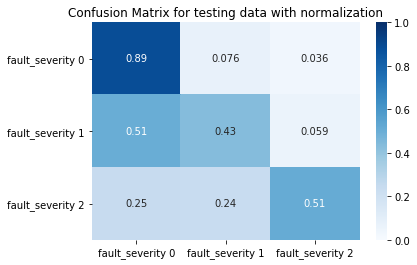

In [8]:
from telstra_helper import logloss_confmat
from sklearn.ensemble import RandomForestClassifier

# train benchmark model
benchmark_model = RandomForestClassifier(n_estimators=100, random_state=45)
print(benchmark_model)

benchmark_model.fit(X_train, y_train)

# evaluate the model by log loss and confusion matrix
benchmark_result = logloss_confmat(benchmark_model, X_train, y_train, X_test, y_test, savefile='benchmark_onehot')


## 4. Train my models

Benchmark model is bad about identifying fault severity 1. Models need to deal with imbalanced class.

Next I will train models below with 'class_weight' parameter:

 - Random Forest
 - LightGBM
 - Deep Neural Networks

In [9]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### Random Forest (parameter tuning)

In [10]:
param_rf = {'max_depth': [10, 20, 50],
            'min_samples_split': [5, 10, 20],
            'n_estimators': [100, 200, 300]}

# grid seach to determine optimal parameters
rf_grid = RandomForestClassifier(class_weight='balanced')
gs_rf = GridSearchCV(rf_grid, param_grid=param_rf, cv=4, verbose=5, scoring='neg_log_loss')
gs_rf.fit(X_train, y_train)

# see the best parameters
print(gs_rf.best_estimator_)
print(gs_rf.best_score_)


Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.8238861965724252, total=   1.5s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.835977710815696, total=   1.4s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.812746324077603, total=   1.4s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=-0.8383828170625472, total=   1.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.8088538292276287, total=   2.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.8283973990436717, total=   2.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.8265663793160748, total=   2.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=200, score=-0.8332245505283312, total=   2.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=-0.8187209151479569, total=   4.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=300 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=300, score=-0.8229056005212017, total=   3.9s
[CV] max_depth=10, min_samples_split=5, n_est

[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.6988653168080515, total=   4.7s
[CV] max_depth=20, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.7173868918119424, total=   4.7s
[CV] max_depth=20, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.7122093625229216, total=   4.7s
[CV] max_depth=20, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=-0.729197708371946, total=   4.8s
[CV] max_depth=20, min_samples_split=10, n_estimators=300 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=300, score=-0.7044446203834579, total=   7.0s
[CV] max_depth=20, min_samples_split=10, n_estimators=300 ............
[CV]  max_depth=20, min_samples_split=10, n_estimators=300, score=-0.7172946140124984, total=   7.1s
[CV] max_depth=20, min_samples_split=10,

[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6193691686191952, total=  11.7s
[CV] max_depth=50, min_samples_split=20, n_estimators=200 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6314094947464922, total=  11.6s
[CV] max_depth=50, min_samples_split=20, n_estimators=200 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6318469093391673, total=  12.0s
[CV] max_depth=50, min_samples_split=20, n_estimators=200 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=200, score=-0.6477063663825675, total=  10.3s
[CV] max_depth=50, min_samples_split=20, n_estimators=300 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=300, score=-0.6170760731168001, total=  11.2s
[CV] max_depth=50, min_samples_split=20, n_estimators=300 ............
[CV]  max_depth=50, min_samples_split=20, n_estimators=300, score=-0.6262811394885289, total=  11.5s
[CV] max_depth=50, min_samples_split=20

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 11.3min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
-0.5917082238277526



***** training *****
 log loss for train = 0.34448339815786855
 --- confusion matrix ---
[[3459  270  111]
 [  73 1376   31]
 [   0    5  579]]

***** testing *****
 log loss for test = 0.5839997881123595
 --- confusion matrix ---
[[774 110  60]
 [118 229  44]
 [  8  30 104]]


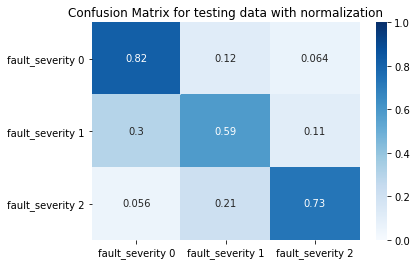

In [11]:
# train the model with the best parameters
rf_clf_best = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_split=5, \
                                     class_weight='balanced', random_state=45)
rf_clf_best.fit(X_train, y_train)

# predict labels and evaluate the result
rf_result = logloss_confmat(rf_clf_best, X_train, y_train, X_test, y_test, savefile="rf_best_onehot")


### LightGBM

**Install:**

```> pip install lightgbm ```

**installed version:**

2.2.2

**Document for parameters:**

[LightGBM scikit-learn API](https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api)

About Parameter Tuning, see [this page](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

Some important parameters are:

- ```num_leaves```:  This is the main parameter to control the complexity of the tree model. Should be smaller than 2^(max_depth)
- ```min_data_in_leaf```: This is a very important parameter to prevent over-fitting in a leaf-wise tree. Large value can avoid growing too deep a tree, but may cause underfitting. Hundreds or thousands is enough for a large dataset.
 
- ```max_bin```: large value for better accuracy

In [12]:
param_lgb = {"min_data_in_leaf": [5, 6, 7], 
             "num_leaves": [50, 55, 60, 70],
             # "feature_fraction": [1, 0.8, 0.5]
             "feature_fraction": [0.5]
              }

# grid seach to determine optimal parameters
lgb_clf_grid = lgb.LGBMClassifier(max_bin=512, class_weight='balanced')
gs_lgb = GridSearchCV(lgb_clf_grid, param_grid=param_lgb, cv=4, verbose=5, scoring='neg_log_loss')
gs_lgb.fit(X_train, y_train)

# see the best parameters
print(gs_lgb.best_estimator_)
print(gs_lgb.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50, score=-0.5986567797497572, total=   2.8s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50, score=-0.606322200528091, total=   2.9s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50, score=-0.6318693032334874, total=   3.1s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50 .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=50, score=-0.6400548853580301, total=   2.8s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55 .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.1s remaining:    0.0s


[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55, score=-0.5996361927291015, total=   2.7s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55, score=-0.6015352929120675, total=   3.4s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55, score=-0.6330223662398041, total=   2.8s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=55, score=-0.6410777860881964, total=   2.8s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=60 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=60, score=-0.5976155073899598, total=   4.4s
[CV] feature_fraction=0.5, min_data_in_leaf=5, num_leaves=60 .........
[CV]  feature_fraction=0.5, min_data_in_leaf=5, num_leaves=60, score=-0.5983259448428522, total=   3.1s
[CV] feature_fraction

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  5.3min finished


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, feature_fraction=0.5,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=5, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
-0.6165707222134525


C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Chieko\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



***** training *****
 log loss for train = 0.38294294815560626
 --- confusion matrix ---
[[3128  548  164]
 [  96 1324   60]
 [   1    6  577]]

***** testing *****
 log loss for test = 0.599362129151942
 --- confusion matrix ---
[[736 146  62]
 [ 85 258  48]
 [ 11  21 110]]


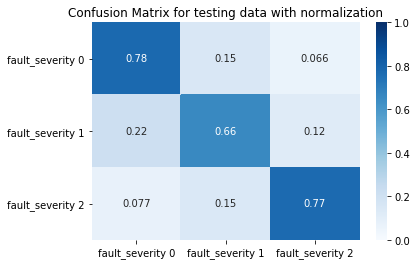

In [13]:
# train the model with the best parameters
lgb_best_clf = lgb.LGBMClassifier(feature_fraction=0.5, min_data_in_leaf=5, num_leaves=60, \
                                  max_bin=512, class_weight='balanced', random_state=45)

lgb_best_clf.fit(X_train, y_train)

# predict labels and evaluate the result
lgb_result = logloss_confmat(lgb_best_clf, X_train, y_train, X_test, y_test, savefile='lgb_best_onehot')

**Experiment Note:**
    
Classification on fault severity 1 is still not brilliant.

### DNN

**Version**

- Keras = 2.2.2
- Tensorflow = 1.10.0

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras

from telstra_helper import logloss_confmat_dnn

C:\Users\Chieko\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
# Convert X_train, X_test into numpy array
X_train_array = np.array(X_train)
print("X_train: the number of dimensions = {}".format(X_train_array.shape[1]))

X_test_array = np.array(X_test)

# Convert y_train, y_test into categorical array
y_train_array = keras.utils.to_categorical(y_train)
print("y_train: the number of classes = {}".format(y_train_array.shape[1]))

y_test_array = keras.utils.to_categorical(y_test)

X_train: the number of dimensions = 1578
y_train: the number of classes = 3


In [16]:
# Build a DNN model architecture

dnn_model = Sequential()
dnn_model.add(Dense(512, input_shape=(X_train.shape[1], ), activation='relu'))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(16, activation='relu'))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(3, activation='softmax'))

# compile the model
dnn_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
dnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               808448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
__________

In [17]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='dnn_model_onehot_best.hdf5', 
                               verbose=1, save_best_only=True)

# specify class weights manually
class_weight = { 0: 1, 1: 2.2, 2: 2.5}

dnn_model.fit(X_train_array, y_train_array, validation_split=0.25, class_weight=class_weight, \
              shuffle=True, epochs=25, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 4428 samples, validate on 1476 samples
Epoch 1/25
4428/4428 [==============================] - 6s 1ms/step - loss: 1.4427 - val_loss: 1.2361

Epoch 00001: val_loss improved from inf to 1.23607, saving model to dnn_model_onehot_best.hdf5
Epoch 2/25
4428/4428 [==============================] - 5s 1ms/step - loss: 1.3033 - val_loss: 1.1896

Epoch 00002: val_loss improved from 1.23607 to 1.18958, saving model to dnn_model_onehot_best.hdf5
Epoch 3/25
4428/4428 [==============================] - 5s 1ms/step - loss: 1.2309 - val_loss: 1.1919

Epoch 00003: val_loss did not improve from 1.18958
Epoch 4/25
4428/4428 [==============================] - 6s 1ms/step - loss: 1.1889 - val_loss: 1.1801

Epoch 00004: val_loss improved from 1.18958 to 1.18010, saving model to dnn_model_onehot_best.hdf5
Epoch 5/25
4428/4428 [==============================] - 6s 1ms/step - loss: 1.1448 - val_loss: 1.1972

Epoch 00005: val_loss did not improve from 1.18010
Epoch 6/25
4428/4428 [====================


***** training *****
 log loss for train = 0.6070435372815979
 --- confusion matrix ---
[[2589 1066  185]
 [ 187 1142  151]
 [  19  103  462]]

***** testing *****
 log loss for test = 0.6776652267328299
 --- confusion matrix ---
[[623 263  58]
 [ 70 272  49]
 [  9  31 102]]


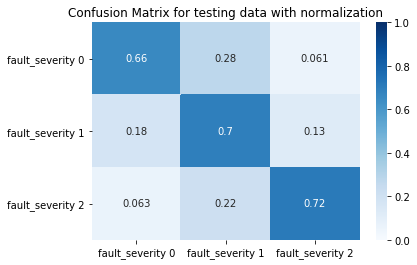

In [18]:
# predict classes and evaluate the result
dnn_model.load_weights('dnn_model_onehot_best.hdf5')
dnn_result = logloss_confmat_dnn(dnn_model, X_train_array, y_train_array, X_test_array, y_test_array, savefile='dnn_onehot')

# Additional examination

### Check Feature Importance


In [19]:
from telstra_helper import print_fi

print_fi(lgb_best_clf.feature_importances_, X_train.columns)

FEATURE: FI VALUE, PERCENT (CUMULATIVE VALUE [PERCENT]) 
--------------------------------------------------
(1) volume 1: 714, 4.03% (714 [4.03%])
(2) volume 2: 488, 2.76% (1202 [6.79%])
(3) volume 4: 371, 2.10% (1573 [8.89%])
(4) volume 3: 342, 1.93% (1915 [10.82%])
(5) event_type 11: 286, 1.62% (2201 [12.44%])
(6) volume 5: 276, 1.56% (2477 [13.99%])
(7) volume 6: 244, 1.38% (2721 [15.37%])
(8) volume 8: 209, 1.18% (2930 [16.55%])
(9) feature 203: 189, 1.07% (3119 [17.62%])
(10) severity_type 2: 186, 1.05% (3305 [18.67%])
(11) feature 193: 177, 1.00% (3482 [19.67%])
(12) severity_type 1: 176, 0.99% (3658 [20.67%])
(13) feature 80: 165, 0.93% (3823 [21.60%])
(14) feature 71: 164, 0.93% (3987 [22.53%])
(15) volume 10: 159, 0.90% (4146 [23.42%])
(16) event_type 15: 155, 0.88% (4301 [24.30%])
(17) feature 68: 145, 0.82% (4446 [25.12%])
(18) volume 7: 145, 0.82% (4591 [25.94%])
(19) resource_type 8: 144, 0.81% (4735 [26.75%])
(20) feature 170: 144, 0.81% (4879 [27.56%])


### Save results

In [20]:
# Put all results from the models into a DataFrame

results_numeric = {'Benchmark_onehot' : benchmark_result,
                   'RandomForest_onehot' : rf_result,
                   'LightGBM_onehot' : lgb_result,
                   'DNN_onehot' : dnn_result
                   }

result_d = {'log_loss': [], 'conf_mat_av': [], 'model': []}

for model, result in results_numeric.items():
    # store test log loss in dict
    result_d['log_loss'].append(result['log_loss'][1])
    
    # store average of correct cells of normalized confusion matrix
    conf_mat_norm = result['conf_mat'][1].astype('float') / result['conf_mat'][1].sum(axis=1)[:, np.newaxis]    
    result_d['conf_mat_av'].append(np.sum(conf_mat_norm*np.eye(3, dtype=float))/3)
    
    result_d['model'].append(model)
    
result_df = pd.DataFrame(result_d)
display(result_df)

# save the result in a file (to be read by numeric version notebook)
result_df.to_csv('result_onehot.csv', index=False)

,log_loss,conf_mat_av,model
0,0.629027,0.612193,Benchmark_onehot
1,0.584000,0.712662,RandomForest_onehot
2,0.599362,0.738052,LightGBM_onehot
3,0.677665,0.691307,DNN_onehot
